# Explainable-AI
CNNs zur Erkennung von Hirntumoren und Anwendung von Layer-wise Relevance Propagation (LRP)

Der Code importiert zentrale PyTorch- und torchvision-Module, um Bilddatensätze zu laden (ImageFolder), Transformationen anzuwenden (transforms) und Daten effizient in Batches zu verarbeiten (DataLoader). Mit random_split können Datensätze für Training und Validierung aufgeteilt werden.

In [37]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

Der Code bereitet den Datensatz für das Training vor. Bilder werden mit Transformationen (Größe ändern, Graustufen, Normalisierung) angepasst und in Tensoren umgewandelt. Anschließend wird der Datensatz in Trainings- und Testdaten aufgeteilt (80/20) und mit DataLoadern für das Batch-Training vorbereitet. Die Klassenlabels (Brain Tumor und Healthy) werden ebenfalls definiert.

In [38]:
# Set batch size
batch_size = 32

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)), # Resize the images
    transforms.Grayscale(num_output_channels=1), # Convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Load the dataset from the folders
dataset = ImageFolder(root='./brain-tumor-data-set', transform=transform)

# Split the dataset
train_size = int(0.8 * len(dataset)) # 80% for training 
test_size = len(dataset) - train_size  # The rest for testing

# Create subsets
trainset, testset = random_split(dataset, [train_size, test_size])

# Create data loaders
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# Define the class names (labels)
classes = ('Brain Tumor', 'Healthy')

Dieser Code visualisiert eine Batch von Trainingsbildern. Die Funktion imshow stellt Bilder dar, indem sie sie denormalisiert und in ein darstellbares Format umwandelt. Mit zufälligen Trainingsdaten aus dem DataLoader werden die Bilder als Grid angezeigt, und die zugehörigen Labels (z. B. Brain Tumor oder Healthy) werden ausgegeben. Dies dient der Überprüfung der Datenqualität und Klassenverteilung.

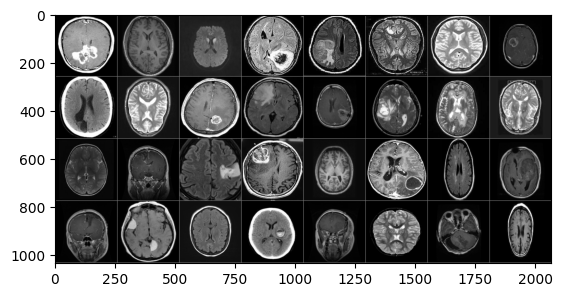

Brain Tumor Healthy Healthy Brain Tumor Brain Tumor Brain Tumor Healthy Brain Tumor Healthy Healthy Brain Tumor Brain Tumor Brain Tumor Brain Tumor Healthy Healthy Healthy Brain Tumor Brain Tumor Brain Tumor Healthy Brain Tumor Healthy Brain Tumor Brain Tumor Brain Tumor Healthy Brain Tumor Brain Tumor Healthy Brain Tumor Healthy


In [39]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images and print labels
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Dieser Code definiert ein Convolutional Neural Network (CNN) mit zwei Convolutional Layers (conv1, conv2) und drei Fully Connected Layers (fc1, fc2, fc3). Die Architektur nutzt ReLU-Aktivierungsfunktionen und ist darauf ausgelegt, Eingabebilder (1 Kanal, Graustufen) zu verarbeiten und sie in zwei Klassen (Brain Tumor, Healthy) zu klassifizieren.

In [40]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.relu1 = nn.ReLU() 
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.relu2 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(20 * 248 * 248, 50)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(50, 10)
        self.fc3 = nn.Linear(10, 2) # 2 Classes (Brain Tumor / Healthy)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

net = Net()

Dieser Code definiert den Trainingsprozess. Die Verlustfunktion ist CrossEntropyLoss, die für Klassifikationsprobleme geeignet ist. Der Optimierer SGD (Stochastic Gradient Descent) aktualisiert die Modellparameter mit einer Lernrate von 0.01 und Momentum von 0.9, um schneller und stabiler zu konvergieren.

In [41]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

Dieser Code implementiert den Trainingsprozess über mehrere Epochen. In jeder Epoche werden die Daten batchweise durch das Modell verarbeitet. Der Verlust wird berechnet (criterion), ein Backpropagation-Schritt durchgeführt, und die Modellparameter werden aktualisiert (optimizer.step()). Alle 500 Batches wird der durchschnittliche Verlust ausgegeben, um den Trainingsfortschritt zu überwachen. Nach Abschluss wird die Trainingsphase beendet.

In [42]:
num_epochs = 5  # Number of epochs to train

for epoch in range(num_epochs):  # Loop over the dataset multiple times
    net.train()  # Set the model to training mode
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        # Zero the parameter gradients after each batch
        optimizer.zero_grad()
        
        # Forward pass
        outputs = net(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item()
        if batch_idx % 500 == 499:  # Print every 100 mini-batches
            print(f'Epoch {epoch+1}, Batch {batch_idx+1}, Loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


Dieser Code speichert die trainierten Modellparameter in einer Datei (cifar_net.pth) unter dem angegebenen Pfad. Mit torch.save können die Parameter später geladen werden, um das Modell ohne erneutes Training zu verwenden.

In [43]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Dieser Code visualisiert eine Batch von Testbildern und gibt die zugehörigen Ground-Truth-Labels aus. Damit wird überprüft, welche Klassen in der Testdaten-Batch enthalten sind und wie die Bilder aussehen, um das Modell später validieren zu können.

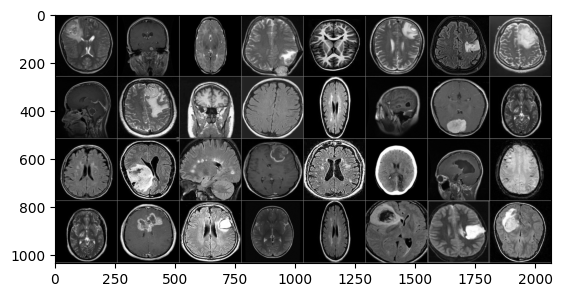

GroundTruth:  Brain Tumor Brain Tumor Healthy Brain Tumor


In [44]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Dieser Code lädt das zuvor gespeicherte Modell (cifar_net.pth) in das neu erstellte Modell net. Mit load_state_dict werden die trainierten Gewichte wieder in das Modell geladen, um es für die Inferenz oder weitere Evaluierungen zu verwenden.

In [45]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

Dieser Code führt eine Vorhersage durch, indem er die geladenen Testbilder (images) durch das Modell net schickt. Die Ausgaben (outputs) sind die Rohvorhersagen des Modells, bevor eine Aktivierungsfunktion oder eine Umwandlung wie softmax angewendet wird, um die finalen Klassenwahrscheinlichkeiten zu erhalten.

In [46]:
outputs = net(images)

Dieser Code verwendet torch.max, um die vorhergesagten Klassen für jedes Bild in der Batch zu extrahieren. predicted enthält die Indizes der maximalen Ausgabewerte (die Klassenvorhersagen) aus den outputs. Anschließend werden diese Vorhersagen ausgegeben, wobei die Klassenbezeichner (Brain Tumor oder Healthy) entsprechend den vorhergesagten Indizes angezeigt werden.

In [47]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  Brain Tumor Brain Tumor Healthy Brain Tumor


Dieser Code evaluiert die Genauigkeit des Modells auf dem Testdatensatz. Während der Inferenz wird die Gradientenberechnung deaktiviert (torch.no_grad()), um den Speicherverbrauch zu reduzieren. Für jedes Testbild wird die Vorhersage gemacht, und die Anzahl der richtigen Vorhersagen wird mit predicted == labels verglichen. Am Ende wird die Gesamtgenauigkeit des Modells auf den Testdaten berechnet und ausgegeben.

In [48]:
correct = 0
total = 0
# Since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculate outputs by running images through the network
        outputs = net(images)
        # The class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 93 %


Dieser Code berechnet die Genauigkeit des Modells für jede einzelne Klasse. Für jede Test-Batch wird überprüft, ob die Vorhersage des Modells mit der tatsächlichen Klasse übereinstimmt, und die korrekten Vorhersagen für jede Klasse werden gezählt. Am Ende wird für jede Klasse die genaue Genauigkeit berechnet und ausgegeben, um zu sehen, wie gut das Modell für jede spezifische Klasse abschneidet.

In [49]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Brain Tumor is 89.9 %
Accuracy for class: Healthy is 97.7 %


Dieser Code implementiert die Anwendung von Layer-wise Relevance Propagation (LRP) auf ein Bild, um die wichtigsten Merkmale für die Modellvorhersage zu visualisieren.

    load_LRP: Lädt das trainierte Modell und bereitet es für LRP vor.
    run_LRP: Wendet LRP auf ein Bild an, um die Relevanzkarte zu berechnen. Zuerst wird das Bild mit den notwendigen Transformationen vorbereitet (Grayscale, Resize, Normalisierung) und dann durch das LRP-Modell geführt.
    create_relevance_map: Unnormalisiert das Eingabebild und visualisiert sowohl das Originalbild als auch die berechnete Relevanzkarte. Letztere zeigt, welche Teile des Bildes die Entscheidung des Modells am meisten beeinflusst haben.

Am Ende wird für ein ausgewähltes Bild eine Relevanzkarte erstellt und visualisiert, die den Beitrag jedes Pixels zur Klassifizierung des Bildes anzeigt.

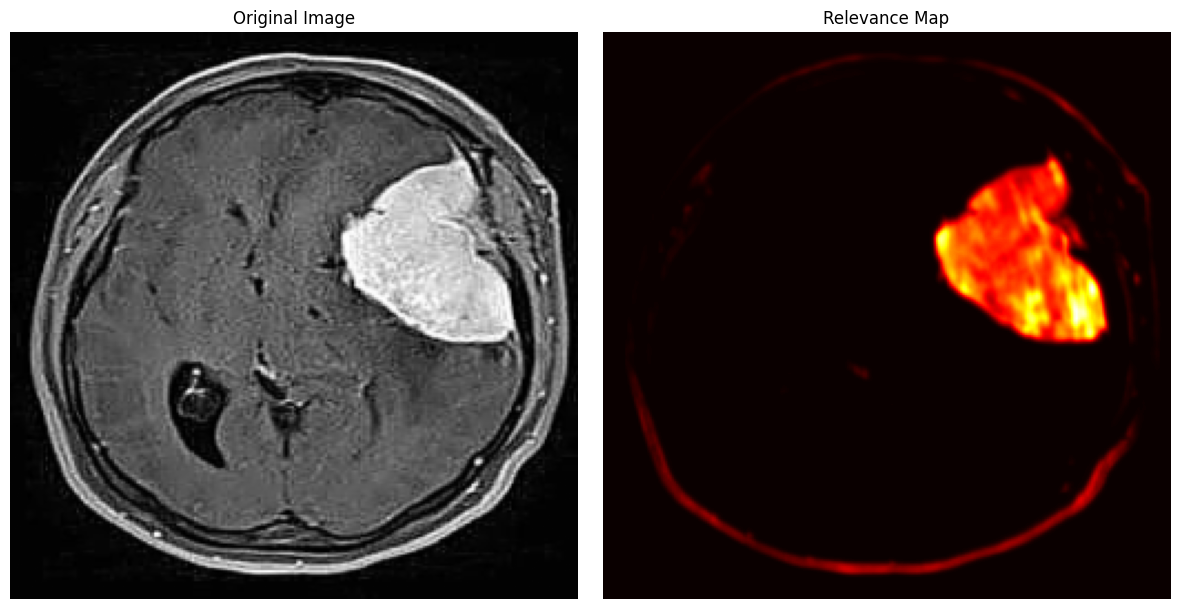

In [109]:
import importlib
import lrp
importlib.reload(lrp)
from lrp import LRPModel
from PIL import Image
import matplotlib.pyplot as plt

def load_LRP():
    net = Net()
    net.load_state_dict(torch.load(PATH, weights_only=True))
    return LRPModel(net)

def run_LRP(lrp_model, image):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    input_tensor = transform(image).unsqueeze(0)  # Load or preprocess an input image tensor
    return lrp_model.forward(input_tensor)

def create_relevance_map(relevance_map, image):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    input_image_np = transform(image).detach().numpy()
    input_image_np = input_image_np.transpose(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    input_image_np = (input_image_np * 0.5 + 0.5)  # Unnormalize to [0, 1]

    relevance_map = (relevance_map - relevance_map.min()) / (relevance_map.max() - relevance_map.min())

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(input_image_np)
    axes[0].set_title("Original Image")
    axes[0].axis('off')  # Hide axes

    axes[1].imshow(relevance_map, cmap='hot')
    axes[1].set_title("Relevance Map")
    axes[1].axis('off')  # Hide axes

    fig.tight_layout()
    plt.show()

image = Image.open('./brain-tumor-data-set/Brain-Tumor/Cancer (2035).jpg')
#image = Image.open('./brain-tumor-data-set/Healthy/Not Cancer  (7).jpg')
lrp_model = load_LRP()
relevance_map = run_LRP(lrp_model, image)
create_relevance_map(relevance_map, image)